### Variance Inflation Factors

/var/folders/ld/rwg8qntx0sg34zkdmmh8mcc80000gp/T/ipykernel_52605/2928172595.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_data_no_const, x="VIF", y="Variable", palette="viridis")


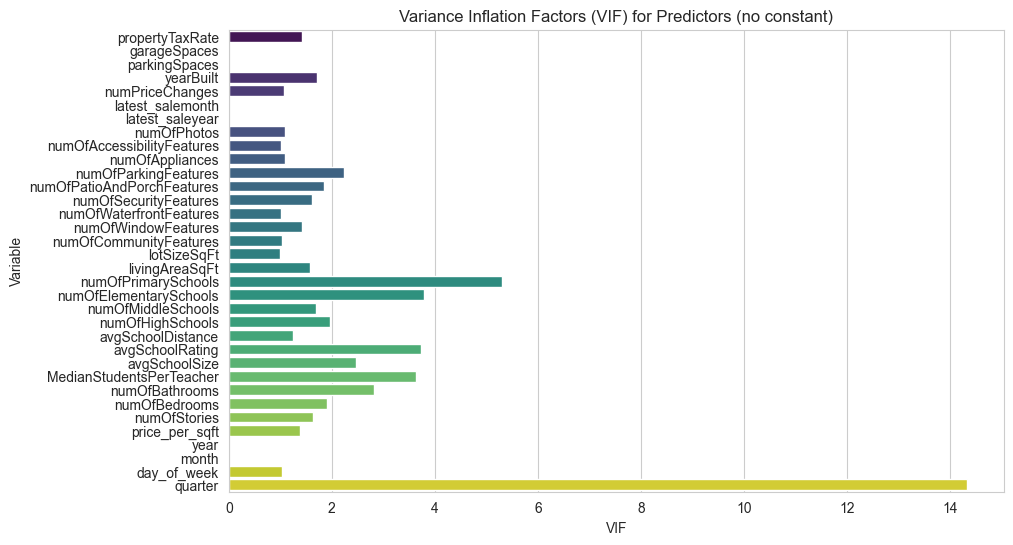

In [44]:
# Remove the constant row
vif_data_no_const = vif_data[vif_data['Variable'] != 'const']

plt.figure(figsize=(10, 6))
sns.barplot(data=vif_data_no_const, x="VIF", y="Variable", palette="viridis")
plt.title("Variance Inflation Factors (VIF) for Predictors (no constant)")
plt.xlabel("VIF")
plt.ylabel("Variable")
plt.show()
    

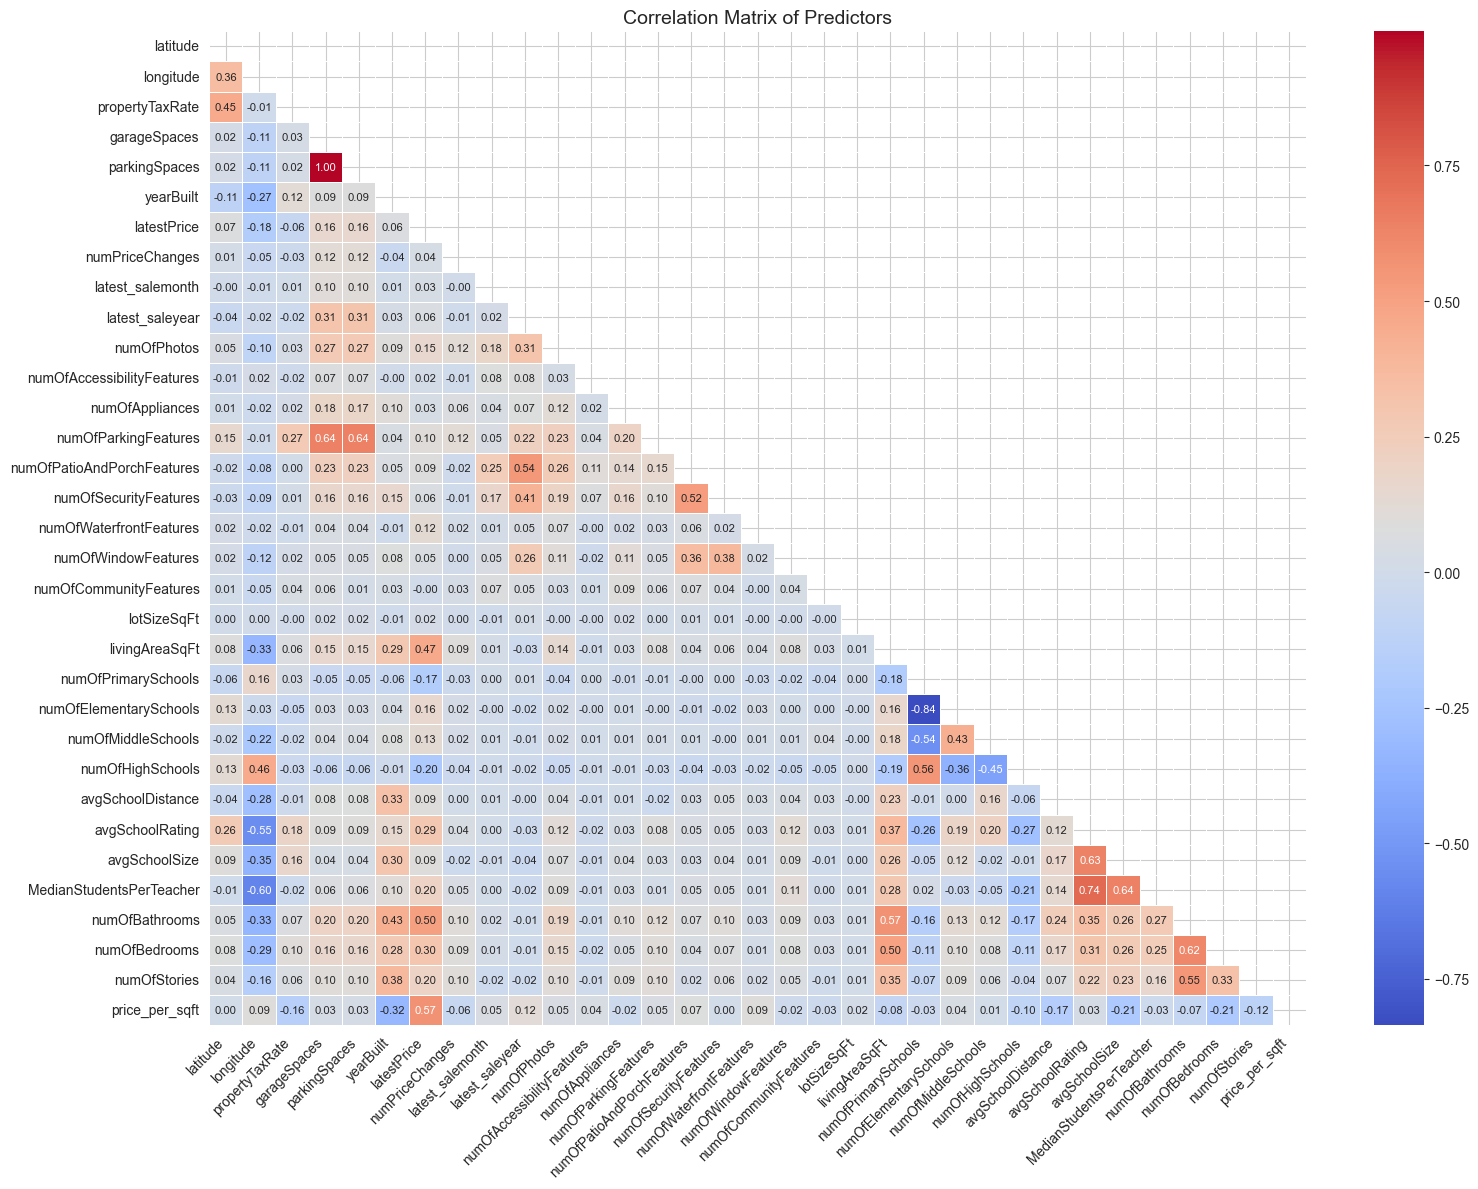

In [89]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(
    corr_matrix, 
    mask=mask,            # Only show lower triangle
    annot=True,           # Show correlation coefficients
    fmt=".2f", 
    cmap='coolwarm', 
    linewidths=0.5, 
    annot_kws={"size": 8} # Reduce annotation font size
)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.title("Correlation Matrix of Predictors", fontsize=14)
plt.tight_layout()
plt.show()

### Divide data to train test split

In [86]:
n_train = int(0.8 * len(df_2))
train = df_2.iloc[:n_train]
test  = df_2.iloc[n_train:]

X_train = train.drop(columns=['latestPrice'])
y_train = train['latestPrice']
X_test = test.drop(columns=['latestPrice'])
y_test = test['latestPrice']
X_train.shape

(11276, 39)

In [77]:
print(X_train.select_dtypes(exclude=['object']).columns)
print(X_train.dtypes)

Index(['latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'parkingSpaces', 'yearBuilt', 'numPriceChanges',
       'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'MORTGAGE30US'],
      dtype='object')
latitude                             float64
longitude                            float64
propertyTaxRate                      float64
garageSpaces    

### Compute local betas using Geographical Weighted Regression 

In [87]:
# GWR USING MGWR: MAIN : output -> local_betas
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# ------------------------------------------------------------------
''' 1) PREP DATA '''

# beta from GWR(features except  ) and then X_train_arra ( all features, except longitude and latitude )

# y_train is a Series of shape (n,).

coords = X_train[['latitude', 'longitude']].values

# X_ is same as X_train_array from math GWR

# dropping : garageSpaces and parkingSpaces are perfectly collinear (their correlation is 1 and their VIFs are infinite)
X_ = X_train.select_dtypes(include=['number']).drop(columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces', 'MORTGAGE30US', 'MEDLISPRIPERSQUFEE12420'],
    errors='ignore'
).values
# mgwr requires y to be shape (n,1) not (n,)
# also y_ is same as y_1 from math GWR
y_ = y_train.values.reshape(-1, 1)

# mgwr also requires an intercept
X_gwr = np.hstack([np.ones((X_.shape[0], 1)), X_])

#--------------------------------------------------------------
""" 2) (OPTION A) MANUALLY SET A FIXED BANDWIDTH """

fixed_bw = 1

gwr_model = GWR(
    coords,       # (n, 2)
    y_,           # (n, 1)
    X_gwr,        # (n, p) [including intercept]
    bw=fixed_bw,
    kernel='gaussian',  # Gaussian kernel
    fixed=True,         # fixed distance bandwidth
    spherical=False
).fit()

local_betas = gwr_model.params  # shape (n, p)
print("Local betas shape:\n", local_betas.shape)


/Users/Chi/Lion's Den/Austin housing price EDA/.venv/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.99146e-19): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/Chi/Lion's Den/Austin housing price EDA/.venv/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.99585e-19): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/Chi/Lion's Den/Austin housing price EDA/.venv/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.99141e-19): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/Chi/Lion's Den/Austin housing price EDA/.venv/lib/python3.12/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.99259e-19): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/Chi/Lion's Den/Austin housing price EDA/.venv/lib/python3.12/site-packages/spglm/iwls.py:37: LinA

Local betas shape:
 (11276, 27)


In [94]:
################################################### Random Forest with Local Slopes #################################################
# MODEL 0 "USING local_betas"
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#################################################################### UPDATE ########################################################################
# We define X_rf using X_train by dropping specific columns.
# We removed from X_train the columns: 'latitude', 'longitude', 'latest_saledate', 'parkingSpaces'.
X_rf = X_train.select_dtypes(include=['number']).drop(
    columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces'],
    errors='ignore').values

# local_betas are obtained from the GWR model; its shape is (n, p).
local_betas = gwr_model.params
print("local_betas shape:", local_betas.shape)

# local_slopes are defined by dropping the intercept column (first column) from local_betas.
# This gives us an array of shape (n, p-1).
local_slopes = local_betas[:, 1:]

# Create the augmented feature matrix by horizontally stacking X_rf and local_slopes.
X_aug = np.hstack([X_rf, local_slopes])
print("Augmented feature shape:", X_aug.shape)

# Flatten the target y for ease of use (from shape (n,1) to (n,)).
y_array = y_.ravel()

# Chronological train-test split: first 80% as training, last 20% as validation.
n_total = X_aug.shape[0]
n_train = int(0.8 * n_total)

X_train_aug = X_aug[:n_train]
y_train_rf = y_array[:n_train]
X_valid_aug = X_aug[n_train:]
y_valid_rf = y_array[n_train:]

# Initialize the Random Forest model with fixed hyperparameters.
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    random_state=11,
    n_jobs=-1
)

# Fit the Random Forest model on the training data.
rf.fit(X_train_aug, y_train_rf)

# Predict on the validation set.
y_pred = rf.predict(X_valid_aug)

# Evaluate the model performance using R^2 and RMSE.
r2 = r2_score(y_valid_rf, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid_rf, y_pred))

print("Random Forest Performance:")
print(f"  R^2:  {r2:.3f}")
print(f"  RMSE: {rmse:,.3f}")


local_betas shape: (11276, 27)
Augmented feature shape: (11276, 53)
Random Forest Performance:
  R^2:  0.777
  RMSE: 196,698.957


In [96]:
#cross validation
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use negative mean squared error as the scoring function.
# cross_val_score returns negative values for errors so we take the absolute later.
scores = cross_val_score(rf, X_train_aug, y_train_rf, scoring='neg_mean_squared_error', cv=cv)

# Convert MSE scores to RMSE
rmse_scores = np.sqrt(-scores)

print("Cross-Validation RMSE scores:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())

Cross-Validation RMSE scores: [290353.9866313  169553.30811455 296769.82912734 315766.67782742
 195779.8723736 ]
Average RMSE: 253644.73481484293


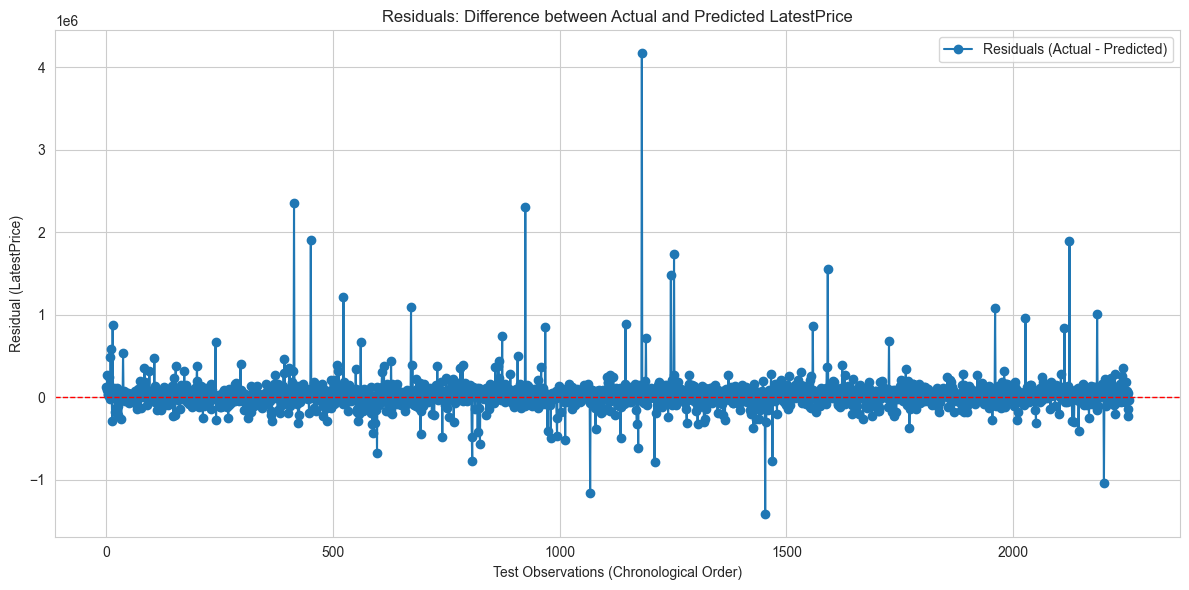

In [98]:
# RESIDUAL PLOTS 
residuals = y_valid_rf - y_pred

# Create an x-axis corresponding to the chronological order (the index within the test set)
x_axis = np.arange(len(residuals))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, residuals, marker='o', linestyle='-', label='Residuals (Actual - Predicted)')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # reference line at 0 error
plt.xlabel('Test Observations (Chronological Order)')
plt.ylabel('Residual (LatestPrice)')
plt.title('Residuals: Difference between Actual and Predicted LatestPrice')
plt.legend()
plt.tight_layout()
plt.show()


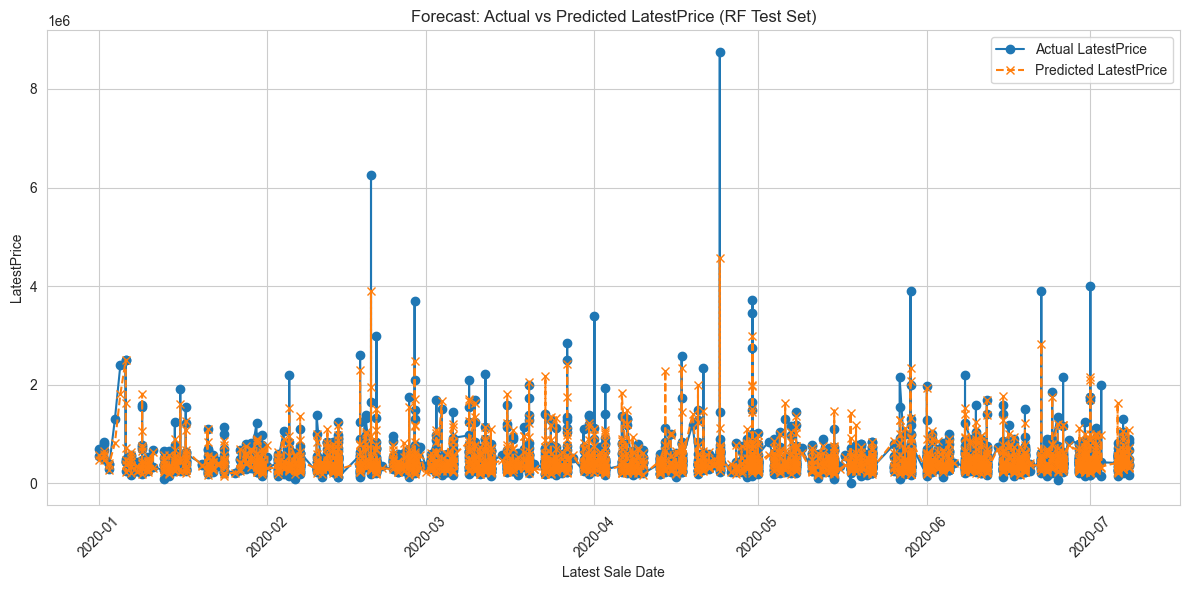

In [101]:
# Save the sale dates from the training set for later plotting
train_dates = train['latest_saledate'].values
# Chronological split on the RF data (which comes from the training set)
n_rf_total = X_aug.shape[0]    
n_rf_train = int(0.8 * n_rf_total)

X_train_aug = X_aug[:n_rf_train]
y_train_rf = y_array[:n_rf_train]
X_valid_aug = X_aug[n_rf_train:]
y_valid_rf = y_array[n_rf_train:]

# Get the corresponding sale dates for the RF test set from train_dates
rf_test_dates = train_dates[n_rf_train:]

plt.figure(figsize=(12, 6))
plt.plot(rf_test_dates, y_valid_rf, label='Actual LatestPrice', marker='o', linestyle='-')
plt.plot(rf_test_dates, y_pred, label='Predicted LatestPrice', marker='x', linestyle='--')
plt.xlabel('Latest Sale Date')
plt.ylabel('LatestPrice')
plt.title('Forecast: Actual vs Predicted LatestPrice (RF Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What change in this file?

- Home Type limited to only Single Family
- Latest salemonth and latest sale year has been removed due to duplicate info with latest saledate
- Adding cross validation